Saving WhatsApp Image 2026-02-03 at 6.45.43 PM (1).jpeg to WhatsApp Image 2026-02-03 at 6.45.43 PM (1) (1).jpeg


/tmp/ipython-input-4225165755.py:36: RuntimeWarning: invalid value encountered in sqrt
  d = np.sqrt((x - ccol)*2 + (y - crow)*2)
/tmp/ipython-input-4225165755.py:45: RuntimeWarning: invalid value encountered in sqrt
  d = np.sqrt((x - ccol)*2 + (y - crow)*2)


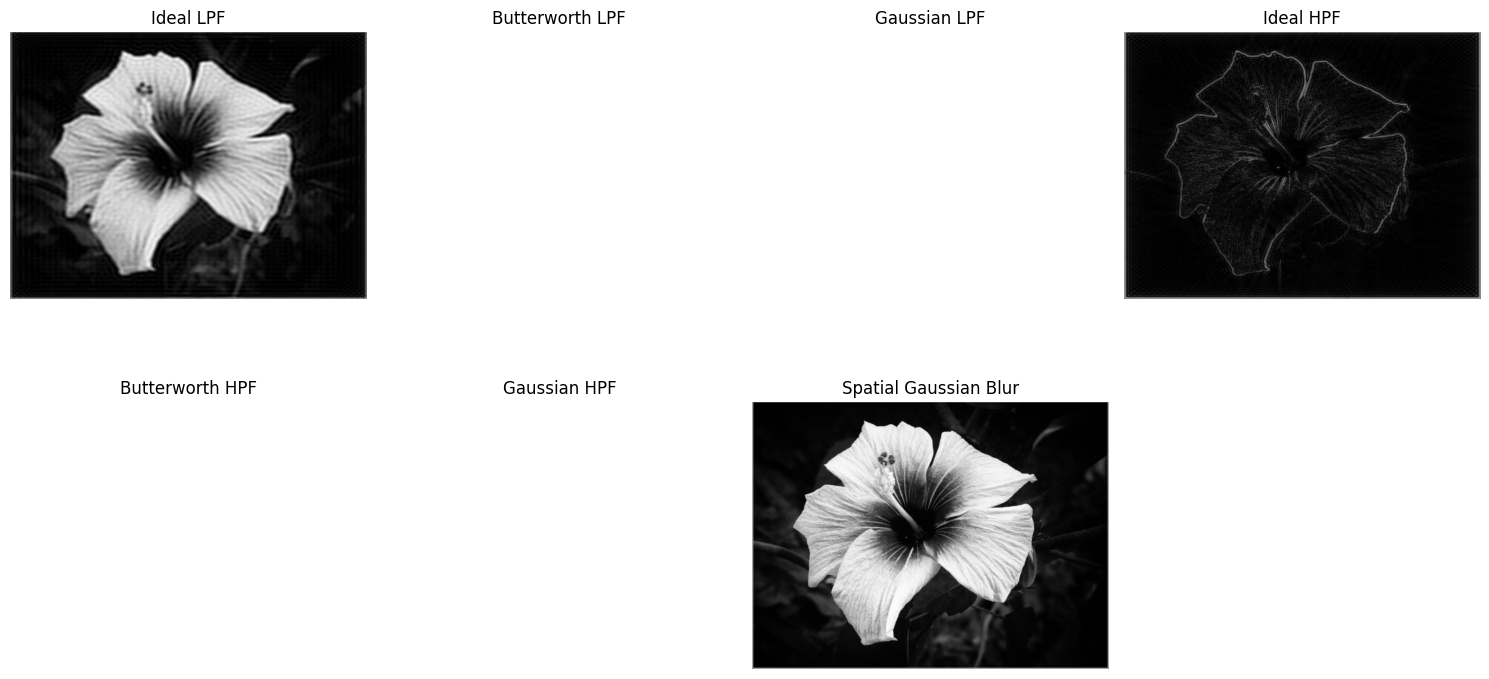

ANALYSIS:
- Low-pass filters remove high-frequency details (smooth/blurred regions).
- High-pass filters emphasize edges and fine details.
- Ideal filter: sharp cutoff, may cause ringing artifacts.
- Butterworth: smoother transition than ideal.
- Gaussian: smoothest frequency transition, natural results.
- Spatial Gaussian blur is simpler but frequency filters provide precise frequency control.


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ----------------------------------
# 1. Upload Image (Colab Safe)
# ----------------------------------
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Load image in grayscale
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Failed to load image!")

# ----------------------------------
# 2. Helper Functions
# ----------------------------------
def compute_fft(img):
    """Compute shifted 2D FFT"""
    return np.fft.fftshift(np.fft.fft2(img.astype(np.float32)))

def create_lpf_ideal(shape, cutoff):
    rows, cols = shape
    crow, ccol = rows//2, cols//2
    mask = np.zeros((rows, cols), np.uint8)
    cv2.circle(mask, (ccol, crow), cutoff, 1, thickness=-1)
    return mask

def create_lpf_butterworth(shape, cutoff, order=2):
    rows, cols = shape
    crow, ccol = rows//2, cols//2
    y = np.arange(0, rows).reshape(rows,1)
    x = np.arange(0, cols)
    d = np.sqrt((x - ccol)*2 + (y - crow)*2)
    mask = 1 / (1 + (d/cutoff)**(2*order))
    return mask

def create_lpf_gaussian(shape, cutoff):
    rows, cols = shape
    crow, ccol = rows//2, cols//2
    y = np.arange(0, rows).reshape(rows,1)
    x = np.arange(0, cols)
    d = np.sqrt((x - ccol)*2 + (y - crow)*2)
    mask = np.exp(-(d*2)/(2*cutoff*2))
    return mask

def create_hpf(lpf_mask):
    return 1 - lpf_mask

def apply_filter(img, mask):
    """Apply filter in frequency domain"""
    fft_img = compute_fft(img)
    filtered_fft = fft_img * mask
    filtered_img = np.fft.ifft2(np.fft.ifftshift(filtered_fft))
    return np.abs(filtered_img)

def display_images(images, titles, rows=2, cols=3):
    """Display multiple images in grid"""
    plt.figure(figsize=(15,8))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ----------------------------------
# 3. Filtering Parameters
# ----------------------------------
cutoff = 60

# ----------------------------------
# 4. Create Masks
# ----------------------------------
lpf_ideal = create_lpf_ideal(image.shape, cutoff)
lpf_butter = create_lpf_butterworth(image.shape, cutoff)
lpf_gauss = create_lpf_gaussian(image.shape, cutoff)

hpf_ideal = create_hpf(lpf_ideal)
hpf_butter = create_hpf(lpf_butter)
hpf_gauss = create_hpf(lpf_gauss)

# ----------------------------------
# 5. Apply Filters
# ----------------------------------
filtered_images = [
    apply_filter(image, lpf_ideal),
    apply_filter(image, lpf_butter),
    apply_filter(image, lpf_gauss),
    apply_filter(image, hpf_ideal),
    apply_filter(image, hpf_butter),
    apply_filter(image, hpf_gauss),
    cv2.GaussianBlur(image, (5,5), 0)
]

titles = [
    "Ideal LPF", "Butterworth LPF", "Gaussian LPF",
    "Ideal HPF", "Butterworth HPF", "Gaussian HPF",
    "Spatial Gaussian Blur"
]

# ----------------------------------
# 6. Display All Results
# ----------------------------------
display_images(filtered_images, titles, rows=2, cols=4)

# ----------------------------------
# 7. Analysis
# ----------------------------------
print("ANALYSIS:")
print("- Low-pass filters remove high-frequency details (smooth/blurred regions).")
print("- High-pass filters emphasize edges and fine details.")
print("- Ideal filter: sharp cutoff, may cause ringing artifacts.")
print("- Butterworth: smoother transition than ideal.")
print("- Gaussian: smoothest frequency transition, natural results.")
print("- Spatial Gaussian blur is simpler but frequency filters provide precise frequency control.")